In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------------------------------------------
# 0. Paths & config
# -----------------------------------------------------------
cwd = os.path.dirname(os.getcwd())  # move up from notebooks/ to week-3/
print("Adjusted working directory:", cwd)

DATA_PATH = os.path.join(cwd, "data", "raw", "MachineLearningRating_v3.txt")
OUT_CLEAN = os.path.join(cwd, "data", "processed", "clean_machinelearningrating.csv")

print("Raw file exists:", os.path.exists(DATA_PATH))
print("Processed folder exists:", os.path.exists(os.path.dirname(OUT_CLEAN)))

# -----------------------------------------------------------
# 1. Load dataset
# -----------------------------------------------------------
df = pd.read_csv(DATA_PATH, sep="|", low_memory=False)
print("Dataset loaded successfully:", df.shape)
display(df.head())


# -----------------------------------------------------------
# 2. Inspect basic structure
# -----------------------------------------------------------
display(df.dtypes)
display(df.isna().sum())

# -----------------------------------------------------------
# 3. Fix and parse date column
# -----------------------------------------------------------
df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"], errors="coerce")
df["YearMonth"] = df["TransactionMonth"].dt.to_period("M").astype(str)

# -----------------------------------------------------------
# 4. Derived Columns
# -----------------------------------------------------------
df["LossRatio"] = df["TotalClaims"] / df["TotalPremium"].replace(0, np.nan)

print("\nBasic Numerical Summary:")
display(df[["TotalClaims", "TotalPremium", "CustomValueEstimate", "LossRatio"]].describe())

# -----------------------------------------------------------
# 5. Outlier Detection using IQR
# -----------------------------------------------------------
def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

outliers_claims = detect_outliers_iqr(df["TotalClaims"].dropna())
print("Number of TotalClaims outliers:", outliers_claims.shape[0])

# -----------------------------------------------------------
# 6. Loss Ratio by Groups
# -----------------------------------------------------------
def compute_loss(g):
    total_premium = g["TotalPremium"].sum()
    return (g["TotalClaims"].sum() / total_premium) if total_premium != 0 else np.nan

loss_by_province = df.groupby("Province").apply(compute_loss).sort_values(ascending=False)
loss_by_vehicle = df.groupby("VehicleType").apply(compute_loss).sort_values(ascending=False)
loss_by_gender = df.groupby("Gender").apply(compute_loss).sort_values(ascending=False)

print("\nLoss Ratio by Province:")
display(loss_by_province)

print("\nLoss Ratio by Vehicle Type:")
display(loss_by_vehicle)

print("\nLoss Ratio by Gender:")
display(loss_by_gender)

# -----------------------------------------------------------
# 7. Monthly Frequency & Severity
# -----------------------------------------------------------
df_month = df.dropna(subset=["TransactionMonth"]).copy()
df_month = df_month.set_index("TransactionMonth")

monthly_freq = df_month["TotalClaims"].count()
monthly_severity = df_month["TotalClaims"].sum()

monthly_df = pd.DataFrame({
    "ClaimFrequency": [monthly_freq],
    "ClaimSeverity": [monthly_severity]
})

print("\nMonthly frequency & severity:")
display(monthly_df)

# -----------------------------------------------------------
# 8. Top Vehicle Makes / Models by Total Claim Amount
# -----------------------------------------------------------
top_vehicles = (
    df.groupby(["make", "Model"])["TotalClaims"]
      .sum()
      .sort_values(ascending=False)
      .head(20)
)

print("\nTop 20 vehicles by total claims:")
display(top_vehicles)

# -----------------------------------------------------------
# 9. Save the cleaned data
# -----------------------------------------------------------
df.to_csv(OUT_CLEAN, index=False)
print(f"\nCleaned dataset saved to: {OUT_CLEAN}")


Adjusted working directory: c:\Users\bia\Desktop\week-3
Raw file exists: True
Processed folder exists: True
Dataset loaded successfully: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


UnderwrittenCoverID           int64
PolicyID                      int64
TransactionMonth             object
IsVATRegistered                bool
Citizenship                  object
LegalType                    object
Title                        object
Language                     object
Bank                         object
AccountType                  object
MaritalStatus                object
Gender                       object
Country                      object
Province                     object
PostalCode                    int64
MainCrestaZone               object
SubCrestaZone                object
ItemType                     object
mmcode                      float64
VehicleType                  object
RegistrationYear              int64
make                         object
Model                        object
Cylinders                   float64
cubiccapacity               float64
kilowatts                   float64
bodytype                     object
NumberOfDoors               

UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               


Basic Numerical Summary:


,TotalClaims,TotalPremium,CustomValueEstimate,LossRatio
count,1.000098e+06,1.000098e+06,2.204560e+05,618464.000000
mean,6.486119e+01,6.190550e+01,2.255311e+05,0.349885
std,2.384075e+03,2.302845e+02,5.645157e+05,9.286479
min,-1.200241e+04,-7.825768e+02,2.000000e+04,-18.700122
25%,0.000000e+00,0.000000e+00,1.350000e+05,0.000000
50%,0.000000e+00,2.178333e+00,2.200000e+05,0.000000
75%,0.000000e+00,2.192982e+01,2.800000e+05,0.000000
max,3.930921e+05,6.528260e+04,2.655000e+07,2553.600000


Number of TotalClaims outliers: 2793


C:\Users\bia\AppData\Local\Temp\ipykernel_6632\2851065878.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_province = df.groupby("Province").apply(compute_loss).sort_values(ascending=False)
C:\Users\bia\AppData\Local\Temp\ipykernel_6632\2851065878.py:69: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_vehicle = df.groupby("VehicleType").apply(compute_loss).sort_values(ascending=False)



Loss Ratio by Province:


C:\Users\bia\AppData\Local\Temp\ipykernel_6632\2851065878.py:70: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_gender = df.groupby("Gender").apply(compute_loss).sort_values(ascending=False)


Province
Gauteng          1.222018
KwaZulu-Natal    1.082693
Western Cape     1.059472
North West       0.790367
Mpumalanga       0.720897
Free State       0.680758
Limpopo          0.661199
Eastern Cape     0.633813
Northern Cape    0.282699
dtype: float64


Loss Ratio by Vehicle Type:


VehicleType
Heavy Commercial     1.628112
Medium Commercial    1.050251
Passenger Vehicle    1.048198
Light Commercial     0.232066
Bus                  0.137292
dtype: float64


Loss Ratio by Gender:


Gender
Not specified    1.059311
Male             0.883910
Female           0.821879
dtype: float64


Monthly frequency & severity:


,ClaimFrequency,ClaimSeverity
0,1000098,6.486755e+07



Top 20 vehicles by total claims:


make            Model                             
TOYOTA          QUANTUM 2.7 SESFIKILE 16s             1.203750e+07
                QUANTUM 2.7 SESFIKILE 15s             1.151173e+07
                QUANTUM 2.7 SESFIKILE 14s             9.967764e+06
                QUANTUM 2.5 D-4D SESFIKILE 16s        7.733236e+06
                HiACE SUPER 16 F/Lift                 3.275205e+06
                HiACE SIYAYA                          1.727756e+06
                QUANTUM 2.5 D-4D 14 SEAT              1.339541e+06
CMC             AMANDLA 2.2                           1.106007e+06
TOYOTA          AVANZA 1.5 SX                         1.089785e+06
MERCEDES-BENZ   SPRINTER 515 CDi HI-ROOF F/C P/V      8.874161e+05
VOLKSWAGEN      CRAFTER 50 2.0 TDi HR 80KW F/C P/V    7.666092e+05
IVECO           50 C15V 15 F/C P/V                    7.504746e+05
MERCEDES-BENZ   SPRINTER 416 CDI HI-ROOF F/C P/V      7.464795e+05
GOLDEN JOURNEY  IBHUBEZI 2.2i                         7.265551e+05
C.A.M      


Cleaned dataset saved to: c:\Users\bia\Desktop\week-3\data\processed\clean_machinelearningrating.csv


In [2]:
import os

# Go up one level from notebooks
cwd = os.path.dirname(os.getcwd())  # now cwd = c:\Users\bia\Desktop\week-3
print("Adjusted working directory:", cwd)

# Correct paths
DATA_PATH = os.path.join(cwd, "data", "raw", "MachineLearningRating_v3.txt")
OUT_CLEAN = os.path.join(cwd, "data", "processed", "clean_machinelearningrating.csv")

# Quick check
print("Raw file exists:", os.path.exists(DATA_PATH))
print("Processed folder exists:", os.path.exists(os.path.dirname(OUT_CLEAN)))

import pandas as pd

# Load dataset
df = pd.read_csv(DATA_PATH, sep="|", low_memory=False)
print("Dataset loaded successfully:", df.shape)

# Preview first rows
display(df.head())

df.to_csv(OUT_CLEAN, index=False)
print("Cleaned dataset saved to:", OUT_CLEAN)





Adjusted working directory: c:\Users\bia\Desktop\week-3
Raw file exists: True
Processed folder exists: True
Dataset loaded successfully: (1000098, 52)


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


Cleaned dataset saved to: c:\Users\bia\Desktop\week-3\data\processed\clean_machinelearningrating.csv


Adjusted working directory: c:\Users\bia\Desktop\week-3


C:\Users\bia\AppData\Local\Temp\ipykernel_6632\4247165388.py:23: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)
C:\Users\bia\AppData\Local\Temp\ipykernel_6632\4247165388.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_province = df.groupby('Province').apply(


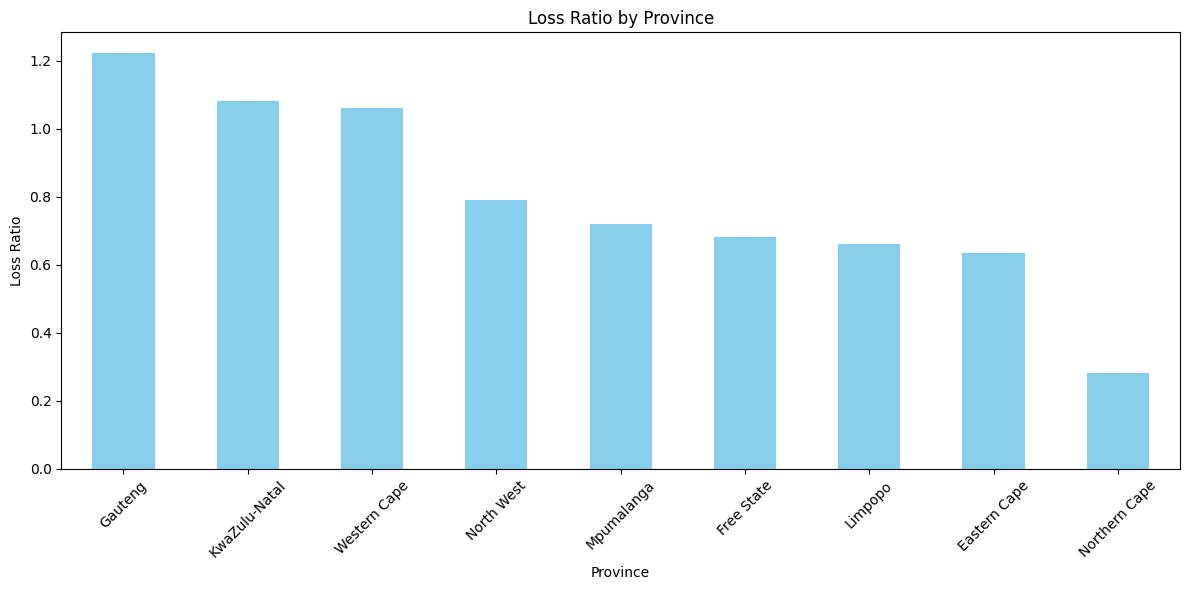

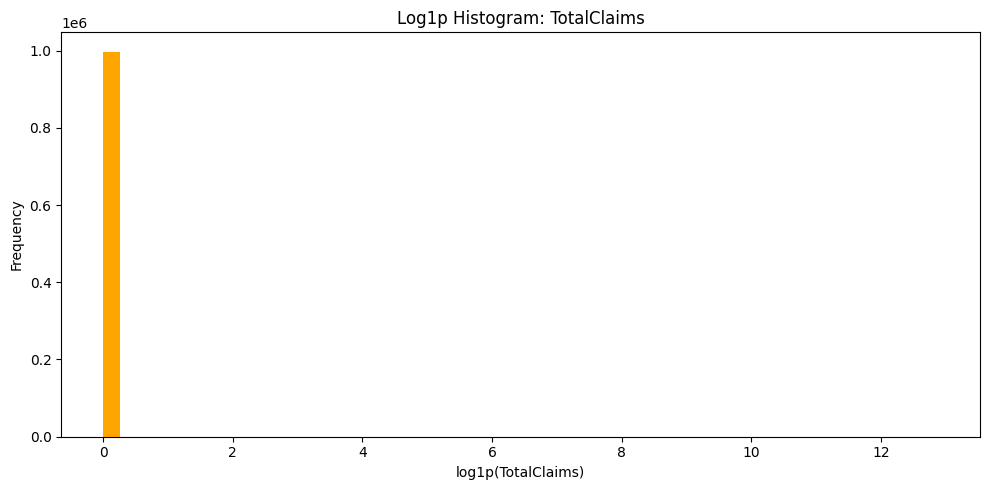

C:\Users\bia\AppData\Local\Temp\ipykernel_6632\4247165388.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_freq = df.set_index('TransactionMonth')['TotalClaims'].gt(0).resample('M').sum()
C:\Users\bia\AppData\Local\Temp\ipykernel_6632\4247165388.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_sev = df.set_index('TransactionMonth')['TotalClaims'].resample('M').mean()


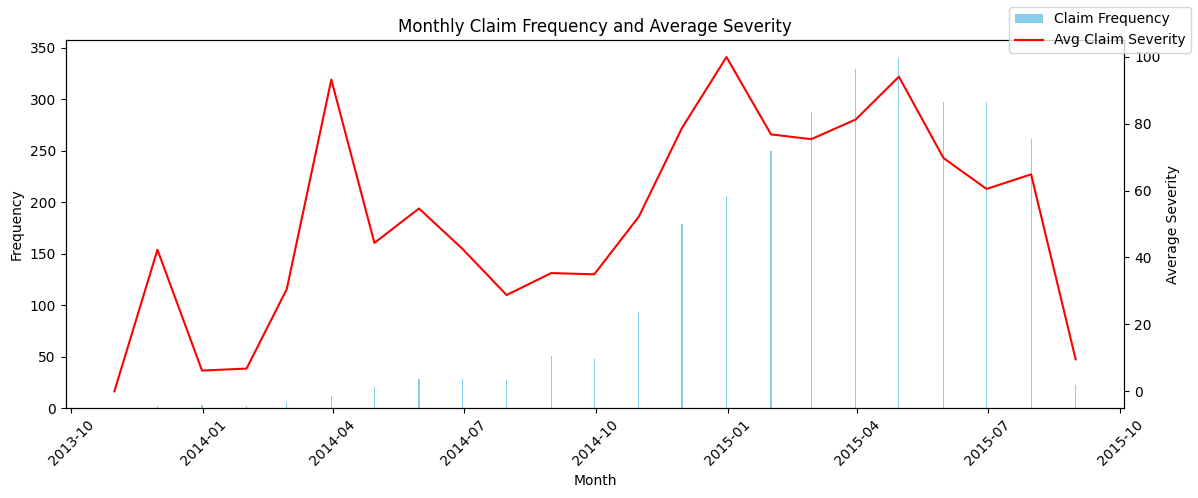

In [3]:
import os
os.chdir("..")  # move one folder up from notebooks to week-3
print("Adjusted working directory:", os.getcwd())

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------------------------------------------------------
# Paths
# ---------------------------------------------------------
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, "data", "processed", "clean_machinelearningrating.csv")
REPORTS_PATH = os.path.join(cwd, "reports")

# Ensure reports folder exists
os.makedirs(REPORTS_PATH, exist_ok=True)

# ---------------------------------------------------------
# Load processed data
# ---------------------------------------------------------
df = pd.read_csv(DATA_PATH)
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# ---------------------------------------------------------
# Plot A — Loss Ratio by Province
# ---------------------------------------------------------
loss_by_province = df.groupby('Province').apply(
    lambda g: g['TotalClaims'].sum()/g['TotalPremium'].sum() if g['TotalPremium'].sum()>0 else np.nan
).dropna().sort_values(ascending=False)

plt.figure(figsize=(12,6))
loss_by_province.plot(kind='bar', color='skyblue')
plt.title('Loss Ratio by Province')
plt.ylabel('Loss Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, 'loss_ratio_by_province.png'), dpi=150)
plt.show()

# ---------------------------------------------------------
# Plot B — Distribution of TotalClaims (log1p)
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
plt.hist(np.log1p(df['TotalClaims'].clip(lower=0)), bins=50, color='orange')
plt.title('Log1p Histogram: TotalClaims')
plt.xlabel('log1p(TotalClaims)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, 'totalclaims_distribution.png'), dpi=150)
plt.show()

# ---------------------------------------------------------
# Plot C — Monthly Claim Frequency & Average Severity
# ---------------------------------------------------------
monthly_freq = df.set_index('TransactionMonth')['TotalClaims'].gt(0).resample('M').sum()
monthly_avg_sev = df.set_index('TransactionMonth')['TotalClaims'].resample('M').mean()

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(monthly_freq.index, monthly_freq.values, color='skyblue', label='Claim Frequency')
ax1.set_xlabel('Month')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(monthly_avg_sev.index, monthly_avg_sev.values, color='red', label='Avg Claim Severity')
ax2.set_ylabel('Average Severity')

fig.legend(loc='upper right')
plt.title('Monthly Claim Frequency and Average Severity')
plt.tight_layout()
plt.savefig(os.path.join(REPORTS_PATH, 'monthly_claims_trends.png'), dpi=150)
plt.show()


In [4]:
# Aggregate loss ratio by Province
loss_by_province = df.groupby('Province').apply(
    lambda g: g['TotalClaims'].sum() / g['TotalPremium'].sum() if g['TotalPremium'].sum() > 0 else np.nan
).sort_values(ascending=False)
display(loss_by_province)

# Aggregate loss ratio by Gender
loss_by_gender = df.groupby('Gender').apply(
    lambda g: g['TotalClaims'].sum() / g['TotalPremium'].sum() if g['TotalPremium'].sum() > 0 else np.nan
)
display(loss_by_gender)


C:\Users\bia\AppData\Local\Temp\ipykernel_6632\1728976423.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_province = df.groupby('Province').apply(


Province
Gauteng          1.222018
KwaZulu-Natal    1.082693
Western Cape     1.059472
North West       0.790367
Mpumalanga       0.720897
Free State       0.680758
Limpopo          0.661199
Eastern Cape     0.633813
Northern Cape    0.282699
dtype: float64

C:\Users\bia\AppData\Local\Temp\ipykernel_6632\1728976423.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loss_by_gender = df.groupby('Gender').apply(


Gender
Female           0.821879
Male             0.883910
Not specified    1.059311
dtype: float64

In [5]:
# Monthly claim frequency (all claims)
monthly_freq = df.set_index('TransactionMonth')['TotalClaims'].count()

# Monthly average severity (only positive claims)
monthly_severity = (
    df[df['TotalClaims'] > 0]
    .set_index('TransactionMonth')['TotalClaims']
    .resample('M')
    .mean()
)

# Combine into a DataFrame
monthly_df = pd.DataFrame({
    'Frequency': monthly_freq,
    'AvgSeverity': monthly_severity
})

display(monthly_df)


C:\Users\bia\AppData\Local\Temp\ipykernel_6632\1258841238.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


,Frequency,AvgSeverity
TransactionMonth,,
2013-11-30,1000098,25292.539474
2013-12-31,1000098,3094.461988
2014-01-31,1000098,6218.429825
2014-02-28,1000098,10498.217836
2014-03-31,1000098,26898.751798
2014-04-30,1000098,15343.179605
2014-05-31,1000098,18513.253095
2014-06-30,1000098,18019.157018
2014-07-31,1000098,15911.766699


In [ ]:
import pandas as pd

df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")

df.head()


# If TransactionMonth should be a datetime:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

# IQR method
Q1 = df['TotalClaims'].quantile(0.25)
Q3 = df['TotalClaims'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[df['TotalClaims'] > Q3 + 1.5*IQR]

# Top 1% claims
top1pct = df['TotalClaims'].quantile(0.99)
top_claims = df[df['TotalClaims'] >= top1pct]
display(top_claims)

df.isna().sum()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()





C:\Users\bia\AppData\Local\Temp\ipykernel_3900\4240583340.py:3: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000093,31520,389,2015-04-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000094,31520,389,2015-06-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000095,31520,389,2015-08-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Third Party,Third Party,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,347.235175,0.0
1000096,31519,389,2014-07-01,False,ZW,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Passenger Liability,Passenger Liability,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,2.315000,0.0


In [3]:
import pandas as pd

# Load processed dataset
df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")

# Convert date column if needed
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Create LossRatio column if not already created
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']

# Gender differences in Loss Ratio
from scipy.stats import ttest_ind, mannwhitneyu

male_lr = df[df['Gender']=='Male']['LossRatio'].dropna()
female_lr = df[df['Gender']=='Female']['LossRatio'].dropna()

# t-test (assumes normality)
t_stat, p_val = ttest_ind(male_lr, female_lr, equal_var=False)
print("T-test p-value:", p_val)

# Mann-Whitney (non-normal)
u_stat, p_val_u = mannwhitneyu(male_lr, female_lr)
print("Mann-Whitney p-value:", p_val_u)

# Province differences
from scipy.stats import f_oneway, kruskal

groups = [g['LossRatio'].dropna() for _, g in df.groupby('Province')]
anova_stat, p_val_anova = f_oneway(*groups)
print("ANOVA p-value:", p_val_anova)

kruskal_stat, p_val_kruskal = kruskal(*groups)
print("Kruskal-Wallis p-value:", p_val_kruskal)



C:\Users\bia\AppData\Local\Temp\ipykernel_2948\1591972184.py:4: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")
c:\Users\bia\Desktop\week-3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:6277: RuntimeWarning: invalid value encountered in scalar subtract
  d = mean1 - mean2
c:\Users\bia\Desktop\week-3\.venv\Lib\site-packages\scipy\stats\_stats_py.py:6831: RuntimeWarning: invalid value encountered in scalar subtract
  estimate = m1 - m2


T-test p-value: nan
Mann-Whitney p-value: 0.5575488876937291


c:\Users\bia\Desktop\week-3\.venv\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


ANOVA p-value: nan
Kruskal-Wallis p-value: 4.0950296336973e-19


In [4]:
# vehicle analysis 
vehicle = df.groupby(['make','Model']).agg(
    total_claims=('TotalClaims','sum'),
    mean_claim=('TotalClaims','mean'),
    n_claims=('TotalClaims','count')
).sort_values('total_claims', ascending=False).head(20)
display(vehicle)

df['VehicleAge'] = 2025 - df['RegistrationYear']
vehicle_age_stats = df.groupby(['make','Model'])['VehicleAge'].mean()


total_claims   mean_claim  \
make           Model                                                           
TOYOTA         QUANTUM 2.7 SESFIKILE 16s           1.203750e+07    64.687504   
               QUANTUM 2.7 SESFIKILE 15s           1.151173e+07    68.717336   
               QUANTUM 2.7 SESFIKILE 14s           9.967764e+06    72.629110   
               QUANTUM 2.5 D-4D SESFIKILE 16s      7.733236e+06    77.764731   
               HiACE SUPER 16 F/Lift               3.275205e+06    41.184595   
               HiACE SIYAYA                        1.727756e+06    42.181535   
               QUANTUM 2.5 D-4D 14 SEAT            1.339541e+06    46.555488   
CMC            AMANDLA 2.2                         1.106007e+06    65.751559   
TOYOTA         AVANZA 1.5 SX                       1.089785e+06    68.851693   
MERCEDES-BENZ  SPRINTER 515 CDi HI-ROOF F/C P/V    8.874161e+05    83.639591   
VOLKSWAGEN     CRAFTER 50 2.0 TDi HR 80KW F/C P/V  7.666092e+05   285.302998   
IVECO          50 C15V 15 F/C P/V                  7.504746e+05   116.424850   
MERCEDES-BENZ  SPRINTER 416 CDI HI-ROOF F/C P/V    7.464795e+05    79.948539   
GOLDEN JOURNEY IBHUBEZI 2.2i                       7.265551e+05    65.715914   
C.A.M          INYATHI                             6.270039e+05    55.659464   
AUDI           A4 1.8T S AVANT MULTITRONIC         5.359957e+05   480.282859   
GOLDEN JOURNEY MAKOYA 2.4i 16S                     5.200274e+05   152.679796   
TOYOTA         QUANTUM 2.5 D-4D SESFIKILE 15s      5.071014e+05    48.125782   
HYUNDAI        H-1 2.5 CRDI WAGON A/T              4.447636e+05  4118.181043   
TOYOTA         L/CRUISER FJ 4.0 V6 CRUISER         3.845499e+05  5340.970273   

                                                   n_claims  
make           Model                                         
TOYOTA         QUANTUM 2.7 SESFIKILE 16s             186087  
               QUANTUM 2.7 SESFIKILE 15s             167523  
               QUANTUM 2.7 SESFIKILE 14s             137242  
               QUANTUM 2.5 D-4D SESFIKILE 16s         99444  
               HiACE SUPER 16 F/Lift                  79525  
               HiACE SIYAYA                           40960  
               QUANTUM 2.5 D-4D 14 SEAT               28773  
CMC            AMANDLA 2.2                            16821  
TOYOTA         AVANZA 1.5 SX                          15828  
MERCEDES-BENZ  SPRINTER 515 CDi HI-ROOF F/C P/V       10610  
VOLKSWAGEN     CRAFTER 50 2.0 TDi HR 80KW F/C P/V      2687  
IVECO          50 C15V 15 F/C P/V                      6446  
MERCEDES-BENZ  SPRINTER 416 CDI HI-ROOF F/C P/V        9337  
GOLDEN JOURNEY IBHUBEZI 2.2i                          11056  
C.A.M          INYATHI                                11265  
AUDI           A4 1.8T S AVANT MULTITRONIC             1116  
GOLDEN JOURNEY MAKOYA 2.4i 16S                         3406  
TOYOTA         QUANTUM 2.5 D-4D SESFIKILE 15s         10537  
HYUNDAI        H-1 2.5 CRDI WAGON A/T                   108  
TOYOTA         L/CRUISER FJ 4.0 V6 CRUISER               72

In [7]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal

# ----------------------------------------------------
# LOAD CLEAN DATA
# ----------------------------------------------------
df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium'].replace(0, np.nan)

# ----------------------------------------------------
# CREATE RESULTS FOLDER
# ----------------------------------------------------
RESULT_DIR = "../reports/task1_results"
os.makedirs(RESULT_DIR, exist_ok=True)
print("Saving results to:", RESULT_DIR)

# ----------------------------------------------------
# 1. MISSING VALUES SUMMARY
# ----------------------------------------------------
missing = df.isna().sum().to_frame("MissingCount")
missing.to_csv(f"{RESULT_DIR}/missing_values.csv")
print("✔ missing_values.csv saved")

# ----------------------------------------------------
# 2. SUMMARY STATISTICS
# ----------------------------------------------------
summary_stats = df.describe(include='all')
summary_stats.to_csv(f"{RESULT_DIR}/summary_statistics.csv")
print("✔ summary_statistics.csv saved")

# ----------------------------------------------------
# 3. OUTLIERS (TOP 1% CLAIMS)
# ----------------------------------------------------
threshold = df['TotalClaims'].quantile(0.99)
outliers = df[df['TotalClaims'] > threshold]
outliers.to_csv(f"{RESULT_DIR}/outliers_top1percent.csv", index=False)
print("✔ outliers_top1percent.csv saved")

# ----------------------------------------------------


# ----------------------------------------------------
# 5. GENDER LOSS RATIO TESTS
# ----------------------------------------------------
male_lr = df[df['Gender'] == 'Male']['LossRatio'].dropna()
female_lr = df[df['Gender'] == 'Female']['LossRatio'].dropna()

t_stat, t_p = ttest_ind(male_lr, female_lr, nan_policy='omit')
mw_stat, mw_p = mannwhitneyu(male_lr, female_lr)

with open(f"{RESULT_DIR}/lossratio_gender_tests.txt", "w") as f:
    f.write("LOSS RATIO — GENDER TESTS\n\n")
    f.write(f"T-test p-value: {t_p}\n")
    f.write(f"Mann-Whitney p-value: {mw_p}\n")

print("✔ lossratio_gender_tests.txt saved")

# ----------------------------------------------------
# 6. PROVINCE DIFFERENCE TESTS
# ----------------------------------------------------
province_groups = [g['LossRatio'].dropna() for _, g in df.groupby("Province")]

# ANOVA
try:
    a_stat, a_p = f_oneway(*province_groups)
except:
    a_p = np.nan

# Kruskal-Wallis
try:
    k_stat, k_p = kruskal(*province_groups)
except:
    k_p = np.nan

with open(f"{RESULT_DIR}/province_tests.txt", "w") as f:
    f.write("LOSS RATIO — PROVINCE TESTS\n\n")
    f.write(f"ANOVA p-value: {a_p}\n")
    f.write(f"Kruskal-Wallis p-value: {k_p}\n")

print("✔ province_tests.txt saved")

# ----------------------------------------------------
# 7. FREQUENCY + SEVERITY SUMMARY TABLE
# ----------------------------------------------------
monthly_freq = df.set_index("TransactionMonth")["TotalClaims"].resample("M").count()
monthly_sev = df[df["TotalClaims"] > 0].set_index("TransactionMonth")["TotalClaims"].resample("M").mean()

monthly_summary = pd.DataFrame({
    "MonthlyFrequency": monthly_freq,
    "MonthlyAverageSeverity": monthly_sev
})
monthly_summary.to_csv(f"{RESULT_DIR}/monthly_trends.csv")
print("✔ monthly_trends.csv saved")

print("\n🎉 All Task 1 results saved successfully!")


C:\Users\bia\AppData\Local\Temp\ipykernel_2948\3655599993.py:9: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/clean_machinelearningrating.csv")


Saving results to: ../reports/task1_results
✔ missing_values.csv saved
✔ summary_statistics.csv saved
✔ outliers_top1percent.csv saved
✔ lossratio_gender_tests.txt saved
✔ province_tests.txt saved


C:\Users\bia\AppData\Local\Temp\ipykernel_2948\3655599993.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_freq = df.set_index("TransactionMonth")["TotalClaims"].resample("M").count()
C:\Users\bia\AppData\Local\Temp\ipykernel_2948\3655599993.py:89: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sev = df[df["TotalClaims"] > 0].set_index("TransactionMonth")["TotalClaims"].resample("M").mean()


✔ monthly_trends.csv saved

🎉 All Task 1 results saved successfully!
